# Lab 8: Implement Your Machine Learning Project Plan

In this lab assignment, you will implement the machine learning project plan you created in the written assignment. You will:

1. Load your data set and save it to a Pandas DataFrame.
2. Perform exploratory data analysis on your data to determine which feature engineering and data preparation techniques you will use.
3. Prepare your data for your model and create features and a label.
4. Fit your model to the training data and evaluate your model.
5. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.

### Import Packages

Before you get started, import a few packages.

In [296]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need for this task.

In [297]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, KMeans

import gensim
from gensim.models import Phrases
from sklearn.metrics import pairwise_distances_argmin_min

## Part 1: Load the Data Set


You have chosen to work with one of four data sets. The data sets are located in a folder named "data." The file names of the three data sets are as follows:

* The "adult" data set that contains Census information from 1994 is located in file `adultData.csv`
* The airbnb NYC "listings" data set is located in file  `airbnbListingsData.csv`
* The World Happiness Report (WHR) data set is located in file `WHR2018Chapter2OnlineData.csv`
* The book review data set is located in file `bookReviewsData.csv`



<b>Task:</b> In the code cell below, use the same method you have been using to load your data using `pd.read_csv()` and save it to DataFrame `df`.

In [298]:
filename = os.path.join(os.getcwd(), "data", "bookReviewsData.csv")
df = pd.read_csv(filename, header=0)

## Part 2: Exploratory Data Analysis

The next step is to inspect and analyze your data set with your machine learning problem and project plan in mind. 

This step will help you determine data preparation and feature engineering techniques you will need to apply to your data to build a balanced modeling data set for your problem and model. These data preparation techniques may include:
* addressing missingness, such as replacing missing values with means
* renaming features and labels
* finding and replacing outliers
* performing winsorization if needed
* performing one-hot encoding on categorical features
* performing vectorization for an NLP problem
* addressing class imbalance in your data sample to promote fair AI


Think of the different techniques you have used to inspect and analyze your data in this course. These include using Pandas to apply data filters, using the Pandas `describe()` method to get insight into key statistics for each column, using the Pandas `dtypes` property to inspect the data type of each column, and using Matplotlib and Seaborn to detect outliers and visualize relationships between features and labels. If you are working on a classification problem, use techniques you have learned to determine if there is class imbalance.


<b>Task</b>: Use the techniques you have learned in this course to inspect and analyze your data. 

<b>Note</b>: You can add code cells if needed by going to the <b>Insert</b> menu and clicking on <b>Insert Cell Below</b> in the drop-drown menu.

In [299]:
# Preparing data by removing duplicates, reset indices, and selecting the relevant data.

df = df.drop_duplicates(subset=["Review"])
df = df.reset_index()
df = df.drop(columns=["index"])
train = df["Review"]

# Check for null values
print(df.isnull().values.any())

False


In [300]:
# Glance over at data
df.describe(include='all')
df

,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True
...,...,...
1860,I purchased the book with the intention of tea...,True
1861,"There are so many design books, but the Graphi...",True
1862,I am thilled to see this book being available ...,True
1863,As many have stated before me the book starts ...,False


In [301]:
# TFIDF Vectorizer
# Customizing list of stop words
custom_stop_words = text.ENGLISH_STOP_WORDS.union(["book", "read", "books", "reading", "ve", "really", "author", "quot", "quot quot"])

tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,3), min_df=4, max_df=.70)
tfidf_vectorizer.fit(train)
tfidf_trained = tfidf_vectorizer.transform(train)

vocabulary_size = len(tfidf_vectorizer.vocabulary_)
print(vocabulary_size)

5698


After experimentation, 8 seems like a solid number of clusters. Less and they start to lose meaning, and more results in multiple clusters of the same theme.

In [302]:
# Word2Vec word embedding

# Pre-processing. Includes tokenization.
pp_train = train.apply(lambda row: gensim.utils.simple_preprocess(row))
bigram_transformer = Phrases(pp_train)
pp_train.head()

# Modeling
word2vec_model = gensim.models.Word2Vec(bigram_transformer[pp_train],
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

# Checking most frequent words
word2vec_model.wv.index_to_key[:25]

['the',
 'and',
 'of',
 'to',
 'is',
 'in',
 'it',
 'that',
 'for',
 'this',
 'book',
 'was',
 'as',
 'with',
 'but',
 'this_book',
 'on',
 'not',
 'are',
 'he',
 'his',
 'or',
 'one',
 'have',
 'you']

Performing too much pre-processing on the word embeddings doesn't seem to work well. Stop words made the clusters a lot worse, so keeping it at just preprocess tokenization and bigrams is probably the best.

In [303]:
# Creating word embeddings
words = set(word2vec_model.wv.index_to_key)
word_embeddings = np.array([np.array([word2vec_model.wv[word] for word in words if word in ex])
                        for ex in pp_train], dtype=object)

word_embeddings[0]

# Creating feature vector
feature_vector = []
for w in word_embeddings:
    if w.size:
        feature_vector.append(w.mean(axis=0))
    else:
        feature_vector.append(np.zeros(100, dtype=float))

In [304]:
# Checking feature vector
for w in range(0, 5):
    print('Length of training example {0}: {1}'.format(w, len(feature_vector[w])))

Length of training example 0: 100
Length of training example 1: 100
Length of training example 2: 100
Length of training example 3: 100
Length of training example 4: 100


## Part 3: Implement Your Project Plan

<b>Task:</b> Use the rest of this notebook to carry out your project plan. You will:

1. Prepare your data for your model and create features and a label.
2. Fit your model to the training data and evaluate your model.
3. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.


Add code cells below and populate the notebook with commentary, code, analyses, results, and figures as you see fit.

In [340]:
# Modeling for clustering (TFIDF)
TFIDF_model = KMeans(random_state=1234)
TFIDF_model.fit(tfidf_trained)
transformer = TFIDF_model.transform(tfidf_trained)
print(TFIDF_model.predict(tfidf_trained))

df["TFIDF Clusters"] = TFIDF_model.labels_
df

[2 2 5 ... 3 1 6]


,Review,Positive Review,TFIDF Clusters,WE Clusters
0,This was perhaps the best of Johannes Steinhof...,True,2,2
1,This very fascinating book is a story written ...,True,2,2
2,The four tales in this collection are beautifu...,True,5,0
3,The book contained more profanity than I expec...,False,1,3
4,We have now entered a second time of deep conc...,True,2,5
...,...,...,...,...
1860,I purchased the book with the intention of tea...,True,1,6
1861,"There are so many design books, but the Graphi...",True,7,3
1862,I am thilled to see this book being available ...,True,3,0
1863,As many have stated before me the book starts ...,False,1,1


In [341]:
#Modeling for clustering (word embedding)
WE_model = KMeans(random_state=1234)
WE_model.fit(feature_vector)
print(WE_model.predict(feature_vector))

df["WE Clusters"] = WE_model.labels_
df

[3 3 0 ... 0 6 6]


,Review,Positive Review,TFIDF Clusters,WE Clusters
0,This was perhaps the best of Johannes Steinhof...,True,2,3
1,This very fascinating book is a story written ...,True,2,3
2,The four tales in this collection are beautifu...,True,5,0
3,The book contained more profanity than I expec...,False,1,7
4,We have now entered a second time of deep conc...,True,2,4
...,...,...,...,...
1860,I purchased the book with the intention of tea...,True,1,5
1861,"There are so many design books, but the Graphi...",True,7,7
1862,I am thilled to see this book being available ...,True,3,0
1863,As many have stated before me the book starts ...,False,1,6


In [342]:
# Checking cluster labels
df.describe(include='all')
print(df["TFIDF Clusters"].unique())
print(df["WE Clusters"].unique())

[2 5 1 6 4 3 0 7]
[3 0 7 4 6 2 5 1]


In [360]:
# Initial analysis
n_words = 15

# Getting top 5 frequent words in each TFIDF cluster
def get_top_words(kmeans, vectorizer, n_words):
    top_words=[]
    for i in range(8):
        centroids = kmeans.cluster_centers_[i]
        top_n_words = np.argsort(centroids)[-n_words:]
        features = vectorizer.get_feature_names()
        top_words.append([features[j] for j in top_n_words])
    return top_words

top_words = get_top_words(TFIDF_model, tfidf_vectorizer, n_words)

for i in range(8):
    print(f"Cluster {i+1}: {', '.join(top_words[i])}")

Cluster 1: mr, written, understand, good, resource, easy, enjoyed, information, story, great great, lot, highly, know, recommend, great
Cluster 2: say, right, think, money, make, want, buy, information, time, know, people, good, don, just, like
Cluster 3: story, christian, chapter, church, god, reader, american, time, people, does, world, new, life, war, history
Cluster 4: man, heart, good, years ago, great, ago, people, wonderful, time, got, story, years, life, like, love
Cluster 5: end, know, ending, way, pages, time, novels, like, character, just, story, series, novel, plot, characters
Cluster 6: thing, writing, far, quite, way, like, time, page, did, loved, children, just, good, written, story
Cluster 7: looking, time, seen, like, make, tips, just, dog, life, boring, little, simple, better, ideas, help
Cluster 8: works, good, lot, using, cd, information, recommend, examples, new, art, helpful, edition, use, text, work


At the moment, some clusters have clear themes: for example, cluster 3 is clearly to do with spirituality and/or history, while cluster 5 has a clear relation to novels and cluster 4 reviews probably have positive themes in them. Howver, a lot of them are still a bit vague just by looking at top words.

In [361]:
# Getting most representative words in each WE cluster
print("Most representative terms per cluster (based on centroids):")
for i in range(8):
    tokens_per_cluster = ""
    most_representative = word2vec_model.wv.most_similar(positive=[WE_model.cluster_centers_[i]], topn=n_words)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: fascinating classic whole itself overall mystery bit while until class important information job character content 
Cluster 1: while job times where completely knowledge question others of_course writer self mind not_only important useful 
Cluster 2: whole information fascinating case until overall itself unfortunately idea entire next extremely class example an_excellent 
Cluster 3: since while job truly clear although useful however made question simple complete completely writer more_than 
Cluster 4: while job times question completely since where writer knowledge useful others mystery important not_only mind 
Cluster 5: almost clear simple since person made simply much_more actually more_than here truly lot_of complete little 
Cluster 6: almost actually here thing am simply person certainly much_more true maybe guy clear reference going 
Cluster 7: certainly thing fun going so_much maybe still here actually almo

Compared to TFIDF, the representative terms for each WE cluster seem to have a lot of repetition between clusters. It's hard to get a grasp on what each cluster could be about, other than maybe some clusters having a philosophical or educational lean.

<IPython.core.display.Javascript object>


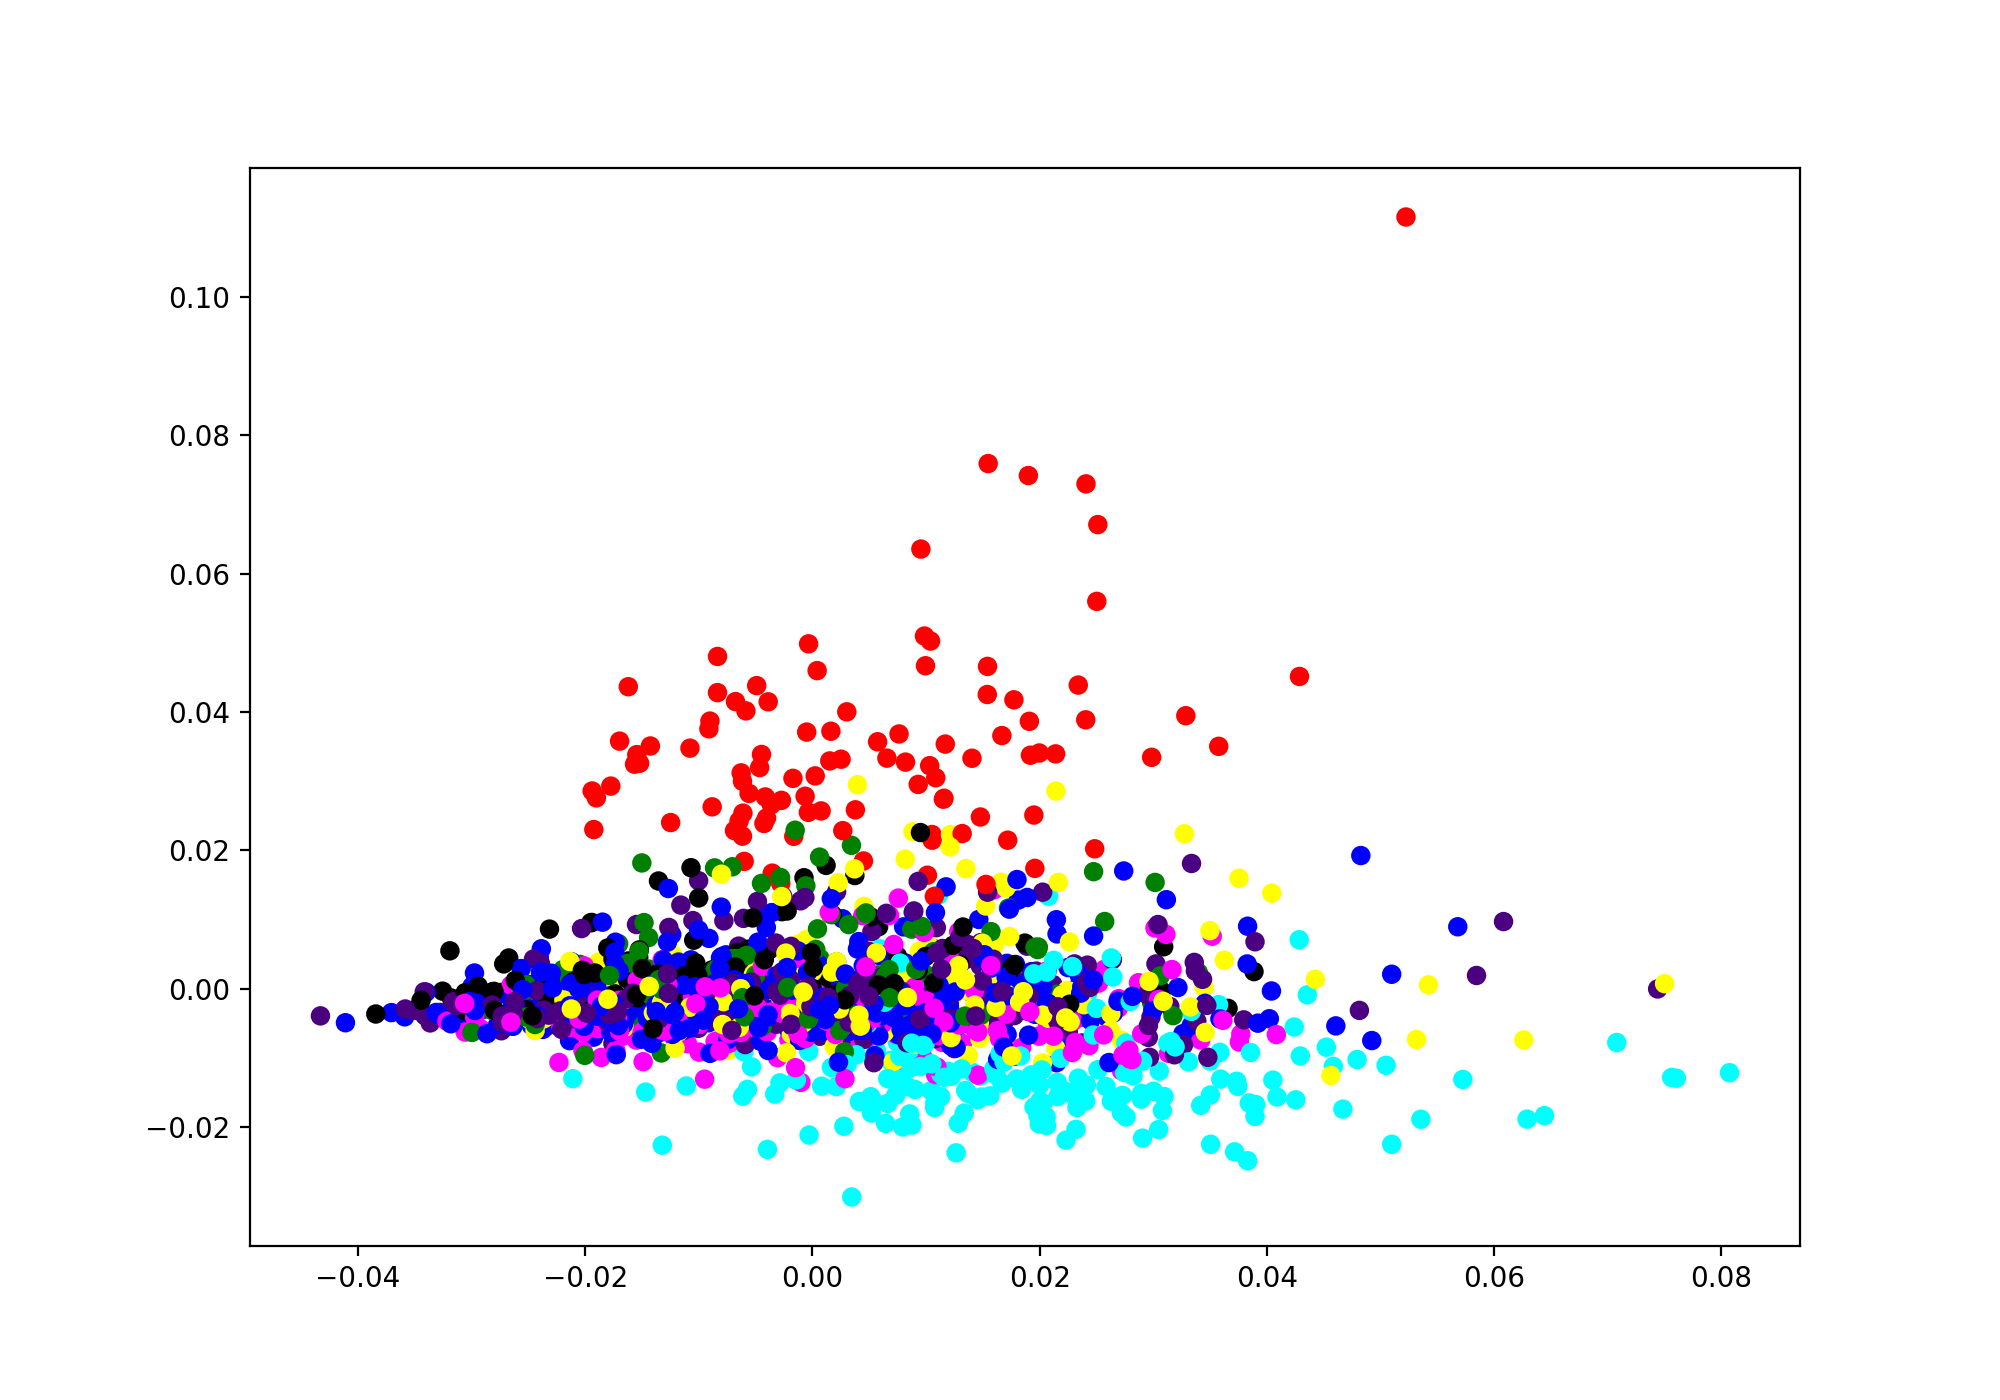

In [372]:
# Looking at TFIDF clusters
%matplotlib notebook

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(transformer)

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(10,7))

colors = ["red", "blue", "indigo", "yellow", "cyan", "magenta", "green", "black"]

ax.scatter(x_axis, y_axis, c=[colors[d] for d in TFIDF_model.labels_])

The TFIDF distribution on the graph seems largely bunched up in one place, with each cluster overlapping each other. The red and cyan clusters do seem to have more of their own regions though.

<IPython.core.display.Javascript object>


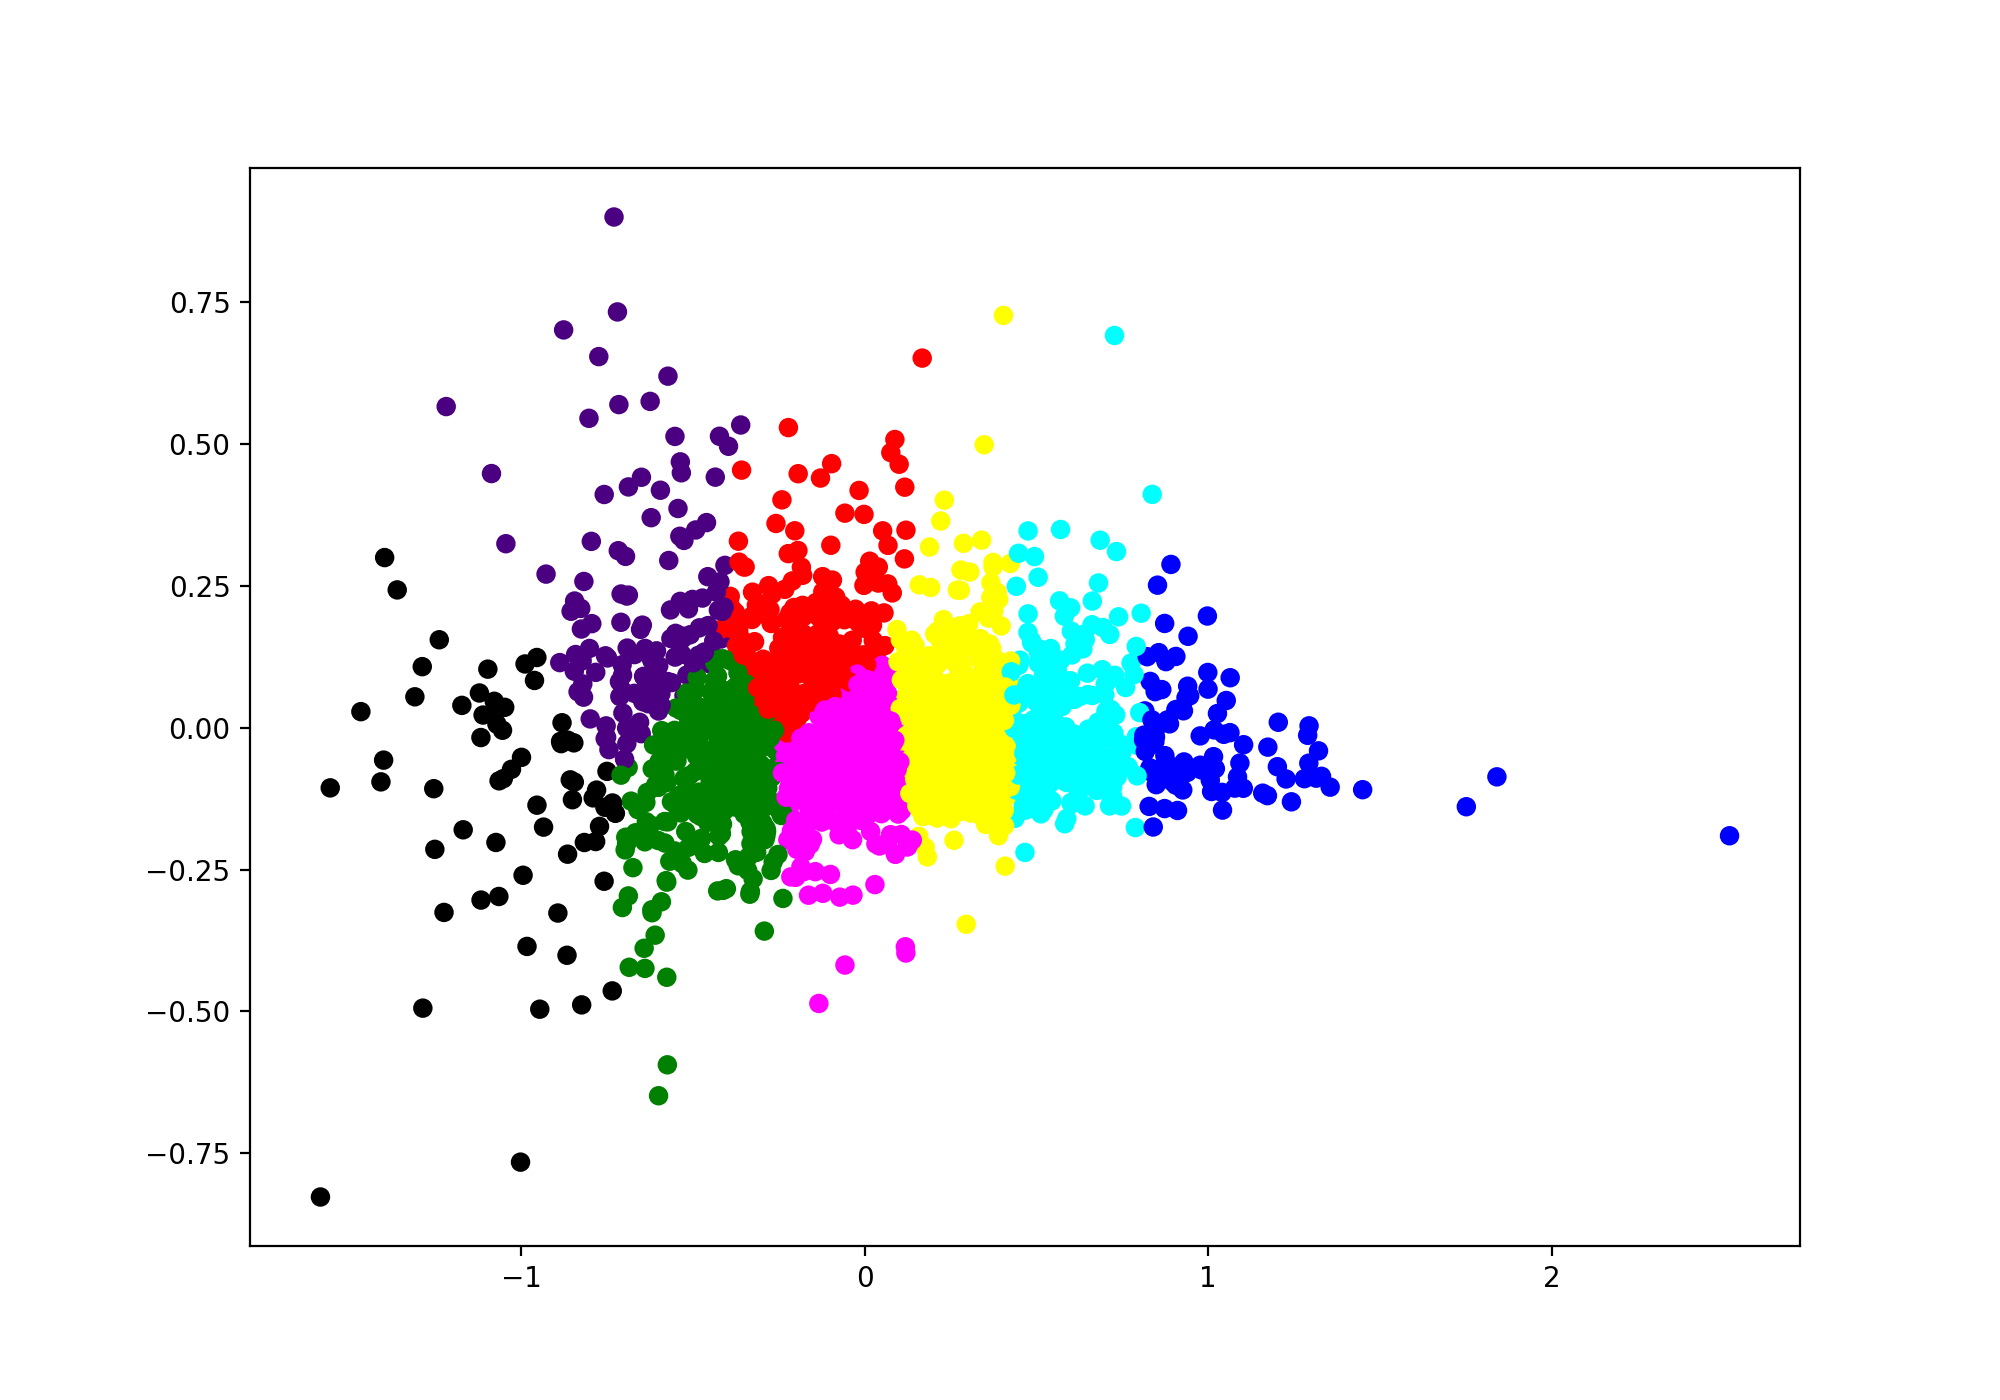

In [373]:
# Looking at WE clusters
%matplotlib notebook

pcat = PCA(n_components=2)
scatter_plot_pointst = pca.fit_transform(feature_vector)

x_axist = [o[0] for o in scatter_plot_pointst]
y_axist = [o[1] for o in scatter_plot_pointst]
figt, axt = plt.subplots(figsize=(10,7))

colors = ["red", "blue", "indigo", "yellow", "cyan", "magenta", "green", "black"]

axt.scatter(x_axist, y_axist, c=[colors[d] for d in WE_model.labels_])

The word embeddings visualization is much more neatly grouped, with pretty much no overlap between the clusters. However, the actual clusters of reviews that WE makes do not seem to be as clearly grouped via semantic meaning.

In [377]:
# Analyzing positive and negative spread in each TFIDF cluster
for i in range(8):
    cluster = (df.loc[df['TFIDF Clusters'] == i])
    print("Cluster " + str(i) + ": " + str(len(cluster)) + " reviews")
    print(cluster['Positive Review'].value_counts())

Cluster 0: 100 reviews
True     78
False    22
Name: Positive Review, dtype: int64
Cluster 1: 478 reviews
False    293
True     185
Name: Positive Review, dtype: int64
Cluster 2: 329 reviews
True     217
False    112
Name: Positive Review, dtype: int64
Cluster 3: 184 reviews
True     135
False     49
Name: Positive Review, dtype: int64
Cluster 4: 176 reviews
False    110
True      66
Name: Positive Review, dtype: int64
Cluster 5: 254 reviews
False    153
True     101
Name: Positive Review, dtype: int64
Cluster 6: 159 reviews
True     84
False    75
Name: Positive Review, dtype: int64
Cluster 7: 185 reviews
True     113
False     72
Name: Positive Review, dtype: int64


In [389]:
# Checking actual reviews
number = 7

cluster = df.loc[df['TFIDF Clusters'] == number]
for i in np.array(cluster["Review"]):
    print(i)
    print("--------------------")

This book would not be helpful for children of faiths other than Christianity

--------------------
This is the greatest unfinished work in all of American literature, and also the best book on filmmaking ever written.  So much compassion and wisdom

--------------------
While this book is a good attempt at placing statistical topics necessary to toxicology in one spot, the mistakes are inexcusable.  Many formula are incorrect as well as text referring to the wrong tables or data. Therefore, one begins to lose trust in the information presented.  Be careful if you use this book

--------------------
The problem with this book is that it does not explain the mathematics well.  The author connects the unsolvable equation with group theory but does not provide any way for the reader to understand exactly what it is that is wrong with the equation.  Why could the equation not be solved?  There is a reason for this fact, and the mathematical theory explains it well--but not this book.  Perh

**Cluster 0:** POS, mostly generic positive reviews that are relatively short

**Cluster 1:** NEG, mostly generic negative reviews that vary in length

**Cluster 2:** POS, strong history, politics, philosophy, etc theme

**Cluster 3:** POS, very slight theme of children? relationships? emotion?

**Cluster 4:** NEG, Reviews of novels/narrative stories

**Cluster 5:** NEG, Very strong negative sentiment towards novels/narrative stories

**Cluster 6:** POS, Slight tutorial/educational theme

**Cluster 7:** POS, Educational, non-narrative book reviews

In [374]:
# Analyzing positive and negative spread in each WE cluster

for i in range(8):
    cluster = (df.loc[df['WE Clusters'] == i])
    print("Cluster " + str(i) + ": " + str(len(cluster)) + " reviews")
    print(cluster['Positive Review'].value_counts())

Cluster 0: 229 reviews
True     133
False     96
Name: Positive Review, dtype: int64
Cluster 1: 90 reviews
True     59
False    31
Name: Positive Review, dtype: int64
Cluster 2: 124 reviews
True     72
False    52
Name: Positive Review, dtype: int64
Cluster 3: 390 reviews
True     197
False    193
Name: Positive Review, dtype: int64
Cluster 4: 255 reviews
True     145
False    110
Name: Positive Review, dtype: int64
Cluster 5: 389 reviews
False    200
True     189
Name: Positive Review, dtype: int64
Cluster 6: 324 reviews
False    171
True     153
Name: Positive Review, dtype: int64
Cluster 7: 64 reviews
False    33
True     31
Name: Positive Review, dtype: int64


In [398]:
# Checking actual reviews
number = 7

cluster = df.loc[df['WE Clusters'] == number]
for i in np.array(cluster["Review"]):
    print(i)
    print("--------------------")

The book contained more profanity than I expected to read in a book by Rita Rudner.  I had expected more humor from a comedienne.  Too bad, because I really like her humor

--------------------
This book would not be helpful for children of faiths other than Christianity

--------------------
The title says it all. One can do better w/ Appleyard's book

--------------------
This was the first Roberts novel I read.  Words cannot describe how much I enjoyed it.  I've read and/or listened to 50 since.  You can't go wrong.  Her storys are original, her characters are strong and well developed. 

--------------------
I believe this will be very helpful for Christian People to understand who God is through the life

--------------------
You will never look at these birds the same again - fansinating

--------------------
It is over a hundred dollars but put it off this is the book. You won't need any others

--------------------
His fragmentary thoughts are difficult to follow. There is some

**Cluster 0:** POS, some slight lean towards non-narrative books, politics.

**Cluster 1:** POS, slight spirituality/philosophical lean

**Cluster 2:** POS, very short and simple reviews

**Cluster 3:** POS (neutral), historical lean

**Cluster 4:** POS, doesn't seem to be a clear theme, maybe slight educational/religious lean?

**Cluster 5:** NEG, some themes of disappointment

**Cluster 6:** NEG, no real theme

**Cluster 7:** NEG (neutral), very short and simple reviews, quite similar to cluster 2

# FINAL THOUGHTS


Ultimately, neither clustering method seems to have created very clear-cut categories from either a semantic or positive/negative perspective. However, TFIDF was much better at extracting themes that made sense, even if the clusters of WE were much more clear when plotted.

From the results of the TFIDF model, the clusters formed were based around both semantic content - what the reviews were talking about and what the books were about, and also sentiment. There were fairly sharp leans in all clusters towards either positive or negative, and both models seemed to take into account length of reviews, with WE being a lot more obvious by having two clusters of exclusively short reviews.

From the TFIDF models, I can gather that there are rough themes around novel/narrative, educational/non-narrative, history/philosophy/politics, and possibly children/relationships/family.